# **1. Import Library**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from collections import Counter
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import (Compose,
                                    RandomResizedCrop, 
                                    Resize,
                                    CenterCrop,
                                    RandomHorizontalFlip, 
                                    RandomVerticalFlip, 
                                    RandomPerspective, 
                                    RandomRotation,
                                    ColorJitter,
                                    Normalize,
                                    ToTensor
                                   )
import torch.optim as optim
from torch.optim import lr_scheduler

# Set random seed
SEED = 0
torch.manual_seed(SEED)  # Set the seed for generating random numbers on CPU
torch.cuda.manual_seed(SEED) if torch.cuda.is_available() else None  # Set the seed for generating random numbers on GPU if available
np.random.seed(SEED)  # Set the seed for generating random numbers with numpy
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior for cuDNN (CUDA Deep Neural Network library)
torch.backends.cudnn.benchmark = False  # Disable cuDNN benchmarking to ensure reproducibility


# **2. Prapare Data**

- **Load data**

In [3]:
# Initialize empty lists to store file paths and labels
paths = []
labels = []

# Dataset path
ds_path = '../hw5/archive/animals/animals'

# Iterate through each category folder
for category in ['cats', 'dogs', 'panda']:

    # Iterate through each file in the category folder
    for p in os.listdir(os.path.join(ds_path, category)):

        # Construct the full path of the file
        f = Path(os.path.join(ds_path, category, p))

        # Append the file path to the list
        paths.append(f)
        
        # Use the name of the parent folder (i.e., category name) as the label and append it to the list
        labels.append(f.parent.stem)

# Count the number of samples in each category
print(Counter(labels))

Counter({'cats': 1000, 'dogs': 1000, 'panda': 1000})


- **Split dataset**

In [4]:
# Split the data into training, validation, and testing sets
# Use train_test_split function from sklearn
# test_size=0.2 means 20% of the data will be used for testing
# random_state=SEED ensures reproducibility of the split
x_train, x_test, y_train, y_test = train_test_split(paths, labels, test_size=0.2, random_state=SEED)

# Further split the training data into training and validation sets
# test_size=0.25 means 25% of the training data will be used for validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=SEED)

# Print the number of samples in each set
print('Number of -  Training  - Set:', len(x_train))
print('Number of - Validation - Set:', len(x_val))
print('Number of -   Testing  - Set:', len(x_test))

Number of -  Training  - Set: 1800
Number of - Validation - Set: 600
Number of -   Testing  - Set: 600


- **Define dataset function**

In [5]:
class AnimalDataset:
    def __init__(self, paths, labels, augmentations):
        # Initialize the dataset with paths to images, their corresponding labels, and augmentation functions
        self.paths = paths
        self.labels = labels

        # Map classes to their corresponding indices
        self.classes = {
            'panda': 0,
            'dogs': 1,
            'cats': 2
        }
        self.augmentations = augmentations
        
    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.paths)
    
    def __getitem__(self, idx):
        # Get a sample and its corresponding label at the given index
        
        # Open the image file located at the specified path and convert it to RGB mode
        sample = Image.open(self.paths[idx]).convert(mode="RGB")

        # Apply augmentation functions to the image sample
        sample = self.augmentations(sample)
        
        # Retrieve the label corresponding to the current sample
        label = self.labels[idx]
        
        # Map the label string to its corresponding index using the classes dictionary
        label = self.classes[label]
        
        # Return the augmented image sample along with its numerical label
        return (sample, torch.tensor(label, dtype=torch.long))


- **Data augmentation**

In [6]:
# Define basic augmentations for the dataset
basic_augmentations = Compose([
    # Resize the image to a square of size 224x224
    Resize(224),

    # Crop the center of the image to size 224x224
    CenterCrop(224),

    # Convert the image to a PyTorch tensor
    ToTensor()
])


# Define more complex augmentations for the dataset
new_augmentations = Compose([
    # Crop a random area of the image and resize it to 224x224
    RandomResizedCrop(224),

    # Flip the image horizontally with a probability of 1 (always)
    RandomHorizontalFlip(1),

    # Flip the image vertically with a probability of 0.1
    RandomVerticalFlip(0.1),

    # Apply a random perspective transformation with a distortion scale of 0.2 and a probability of 0.2
    RandomPerspective(distortion_scale=0.2, p=0.2),

    # Rotate the image by a random angle between -15 and 15 degrees
    RandomRotation(15),

    # Convert the image to a PyTorch tensor
    ToTensor(),
    
    # Normalize the image with the specified mean and standard deviation
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


- **Dataloader**

     - with basic_augmentations

In [7]:
# Create training, validation, and test datasets with basic augmentations
train_data = AnimalDataset(x_train, y_train, basic_augmentations)
val_data   = AnimalDataset(x_test,  y_test,  basic_augmentations)
test_data  = AnimalDataset(x_test,  y_test,  basic_augmentations)

# Create data loaders for training, validation, and test datasets
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, num_workers=2, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_data,   batch_size=100, num_workers=2, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data,  batch_size=100, num_workers=2, shuffle=True)


     - with new_augmentations

In [8]:
# Create training, validation, and test datasets with new augmentations
train_data_new_augmentations = AnimalDataset(x_train, y_train, new_augmentations)
val_data_new_augmentations   = AnimalDataset(x_test,  y_test,  new_augmentations)
test_data_new_augmentations  = AnimalDataset(x_test,  y_test,  new_augmentations)

# Create data loaders for datasets with new augmentations
train_loader_new_augmentations = torch.utils.data.DataLoader(train_data_new_augmentations, batch_size=100, num_workers=2, shuffle=True)
val_loader_new_augmentations   = torch.utils.data.DataLoader(val_data_new_augmentations,   batch_size=100, num_workers=2, shuffle=True)
test_loader_new_augmentations  = torch.utils.data.DataLoader(test_data_new_augmentations,  batch_size=100, num_workers=2, shuffle=True)


# **3. Modeling**

     - Simple CNN 

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Input image size is reduced to 28x28 after pooling
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):

        # Convolutional layers with ReLU activation and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the feature maps
        x = x.view(-1, 128 * 28 * 28)

        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

     - Deeper CNN 

In [10]:
class DeeperCNN(nn.Module):
    def __init__(self, num_classes):
        super(DeeperCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers with dropout
        self.fc1 = nn.Linear(512 * 7 * 7, 1024)  # Input image size is reduced to 7x7 after pooling
        self.dropout = nn.Dropout(0.5)  # Adding dropout with a probability of 0.5
        self.fc2 = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))

        # Flatten the feature maps
        x = x.view(-1, 512 * 7 * 7)
        
        # Fully connected layers with ReLU activation and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



# **4. Training**

In [11]:
def plot_losses(train_losses, val_losses):
    # Plot the training and validation losses
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def plot_accuracies(train_accuracies, val_accuracies):
    # Plot the training and validation accuracies
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

def save_best_model(model, filepath):
    # Save the best-performing model
    torch.save(model.state_dict(), filepath)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, model_path='best_model.pth'):
    # Determine if GPU is available, and move model to GPU if available
    device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Lists to store training and validation losses and accuracies
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    # Initialize best validation accuracy
    best_val_accuracy = 0.0
    
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            # Move images and labels to GPU if available
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Compute training statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Compute training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # Compute validation loss and accuracy
        val_loss /= len(val_loader)
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # Adjust learning rate using scheduler
        scheduler.step()
        
        # Print epoch statistics
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
        
        # Check if validation accuracy improved, if yes, save the model
        if val_accuracy > best_val_accuracy:
            save_best_model(model, model_path)
            best_val_accuracy = val_accuracy
    
    # Plot the loss and accuracy curves
    plot_losses(train_losses, val_losses)
    plot_accuracies(train_accuracies, val_accuracies)

    # Print best result
    print(f"Best validation accuracy: {best_val_accuracy:.4f}")
    print(f"Model with best accuracy saved at: {model_path}")


- **SimpleCNN + basic_augmentations**

Epoch [1/50], Train Loss: 1.5527, Train Acc: 0.4383, Val Loss: 0.9396, Val Acc: 0.4883
Epoch [2/50], Train Loss: 0.7939, Train Acc: 0.6139, Val Loss: 0.7843, Val Acc: 0.6150
Epoch [3/50], Train Loss: 0.7441, Train Acc: 0.6339, Val Loss: 0.8328, Val Acc: 0.5583
Epoch [4/50], Train Loss: 0.7001, Train Acc: 0.6533, Val Loss: 0.8213, Val Acc: 0.5600
Epoch [5/50], Train Loss: 0.5930, Train Acc: 0.7322, Val Loss: 0.7950, Val Acc: 0.6167
Epoch [6/50], Train Loss: 0.5555, Train Acc: 0.7428, Val Loss: 0.7780, Val Acc: 0.6367
Epoch [7/50], Train Loss: 0.4807, Train Acc: 0.7833, Val Loss: 0.8602, Val Acc: 0.6067
Epoch [8/50], Train Loss: 0.4317, Train Acc: 0.8139, Val Loss: 0.8228, Val Acc: 0.6533
Epoch [9/50], Train Loss: 0.3316, Train Acc: 0.8656, Val Loss: 0.8563, Val Acc: 0.6533
Epoch [10/50], Train Loss: 0.2651, Train Acc: 0.8856, Val Loss: 0.9636, Val Acc: 0.6300
Epoch [11/50], Train Loss: 0.1878, Train Acc: 0.9367, Val Loss: 1.0203, Val Acc: 0.6483
Epoch [12/50], Train Loss: 0.1339, Train 

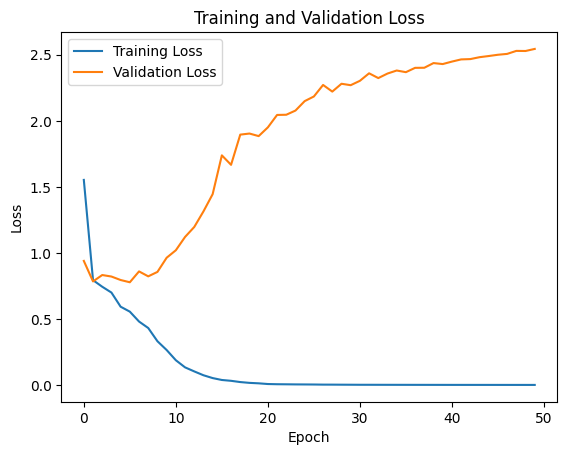

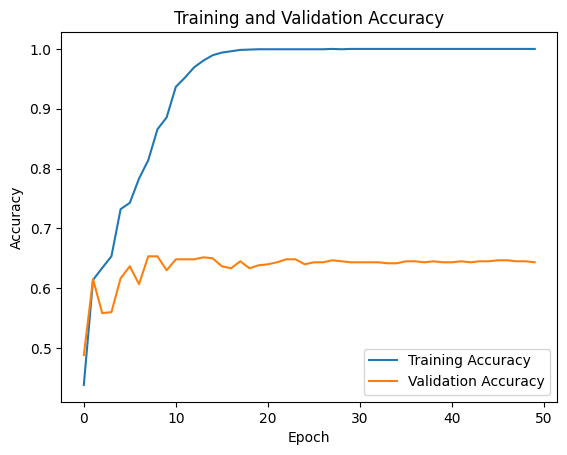

Best validation accuracy: 0.6533
Model with best accuracy saved at: SimpleCNN+basic.pth


In [12]:
# Initialize SimpleCNN model with 3 output classes
model = SimpleCNN(num_classes=3)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam) with specific learning rate and other parameters
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

# Define the learning rate scheduler (StepLR) to adjust learning rate during training
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Number of epochs for training
num_epochs = 50

# Path to save the best model
model_path = 'SimpleCNN+basic.pth'

# Train the model using the provided function
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, model_path)


- **DeeperCNN + basic_augmentations**

Epoch [1/50], Train Loss: 1.0846, Train Acc: 0.3950, Val Loss: 0.9881, Val Acc: 0.4300
Epoch [2/50], Train Loss: 0.8655, Train Acc: 0.5361, Val Loss: 0.8337, Val Acc: 0.5150
Epoch [3/50], Train Loss: 0.7592, Train Acc: 0.6106, Val Loss: 0.8624, Val Acc: 0.5283
Epoch [4/50], Train Loss: 0.7066, Train Acc: 0.6472, Val Loss: 0.8267, Val Acc: 0.5800
Epoch [5/50], Train Loss: 0.6714, Train Acc: 0.6694, Val Loss: 0.7821, Val Acc: 0.5583
Epoch [6/50], Train Loss: 0.6244, Train Acc: 0.6961, Val Loss: 0.7040, Val Acc: 0.6367
Epoch [7/50], Train Loss: 0.6016, Train Acc: 0.7167, Val Loss: 0.6879, Val Acc: 0.6483
Epoch [8/50], Train Loss: 0.5621, Train Acc: 0.7417, Val Loss: 0.7479, Val Acc: 0.6267
Epoch [9/50], Train Loss: 0.5321, Train Acc: 0.7478, Val Loss: 0.7618, Val Acc: 0.6367
Epoch [10/50], Train Loss: 0.4845, Train Acc: 0.7811, Val Loss: 0.7072, Val Acc: 0.6483
Epoch [11/50], Train Loss: 0.4300, Train Acc: 0.8050, Val Loss: 0.7571, Val Acc: 0.6517
Epoch [12/50], Train Loss: 0.4126, Train 

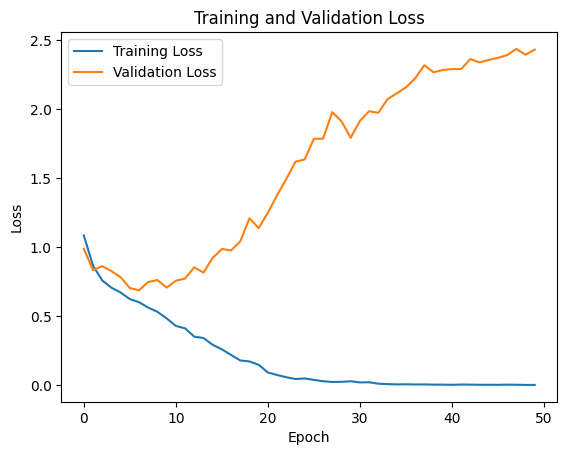

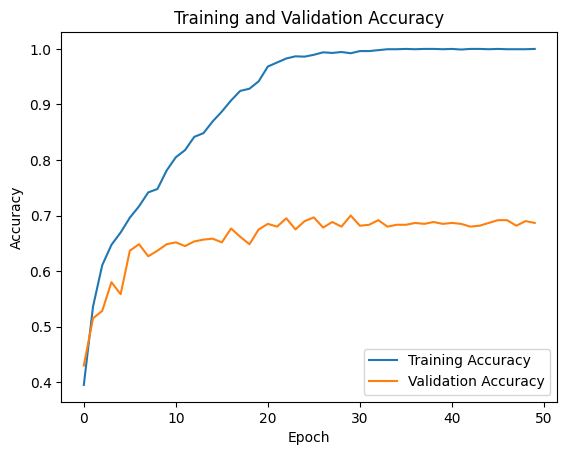

Best validation accuracy: 0.7000
Model with best accuracy saved at: DeeperCNN+basic.pth


In [13]:
# Initialize DeeperCNN model with 3 output classes
model = DeeperCNN(num_classes=3)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam) with specific learning rate and other parameters
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

# Define the learning rate scheduler (StepLR) to adjust learning rate during training
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Number of epochs for training
epoch = 50

# Path to save the best model
model_path = 'DeeperCNN+basic.pth'

# Train the model using the provided function
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epoch, model_path)


- **DeeperCNN + new_augmentations**

Epoch [1/50], Train Loss: 1.0972, Train Acc: 0.4000, Val Loss: 0.9532, Val Acc: 0.4833
Epoch [2/50], Train Loss: 0.9270, Train Acc: 0.5139, Val Loss: 0.9124, Val Acc: 0.4983
Epoch [3/50], Train Loss: 0.8701, Train Acc: 0.5589, Val Loss: 0.8569, Val Acc: 0.5383
Epoch [4/50], Train Loss: 0.8435, Train Acc: 0.5722, Val Loss: 0.8248, Val Acc: 0.5867
Epoch [5/50], Train Loss: 0.8043, Train Acc: 0.6006, Val Loss: 0.9157, Val Acc: 0.5067
Epoch [6/50], Train Loss: 0.8284, Train Acc: 0.5922, Val Loss: 0.8487, Val Acc: 0.5533
Epoch [7/50], Train Loss: 0.7912, Train Acc: 0.6183, Val Loss: 0.8686, Val Acc: 0.5500
Epoch [8/50], Train Loss: 0.7627, Train Acc: 0.6250, Val Loss: 0.7822, Val Acc: 0.6033
Epoch [9/50], Train Loss: 0.7819, Train Acc: 0.6078, Val Loss: 0.8860, Val Acc: 0.5467
Epoch [10/50], Train Loss: 0.7203, Train Acc: 0.6572, Val Loss: 0.7927, Val Acc: 0.6167
Epoch [11/50], Train Loss: 0.7072, Train Acc: 0.6644, Val Loss: 0.7716, Val Acc: 0.6200
Epoch [12/50], Train Loss: 0.6735, Train 

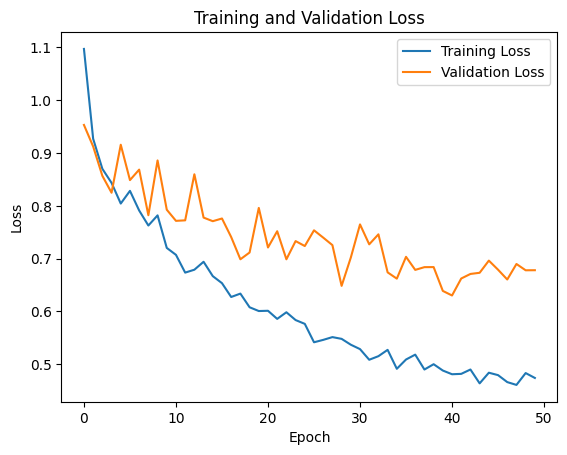

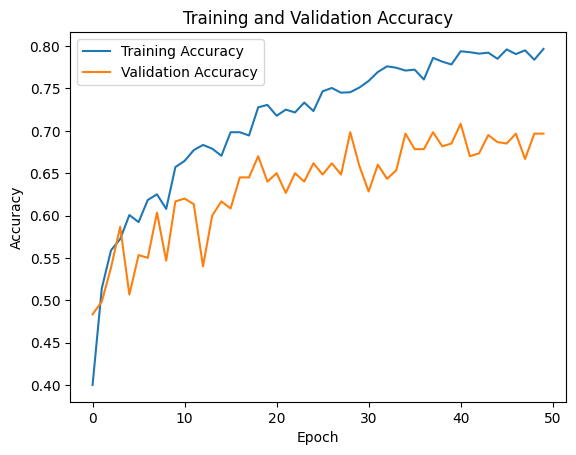

Best validation accuracy: 0.7083
Model with best accuracy saved at: DeeperCNN+new.pth


In [14]:
# Initialize DeeperCNN model with 3 output classes
model = DeeperCNN(num_classes=3)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam) with specific learning rate and other parameters
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

# Define the learning rate scheduler (StepLR) to adjust learning rate during training
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Number of epochs for training
epoch = 50

# Path to save the best model
model_path = 'DeeperCNN+new.pth'

# Train the model using the provided function, with new augmentations
train_model(model, train_loader_new_augmentations, val_loader_new_augmentations, criterion, optimizer, scheduler, epoch, model_path)

# **5. Evaluation**

In [24]:
# Define a function to test the model
def test_model(model, test_loader, criterion):
    # Check if CUDA is available and move model to GPU if it is
    device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize variables to track loss, correct predictions, total samples, predicted labels, and true labels
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    predictions = []
    true_labels = []
    
    # Iterate through the test loader
    with torch.no_grad():
        for images, labels in test_loader:
            # Move images and labels to GPU if available
            images, labels = images.to(device), labels.to(device)
            # Perform forward pass
            outputs = model(images)
            # Compute loss
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            # Compute number of correct predictions
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()
            # Compute total number of samples
            test_total += labels.size(0)
            # Store predicted and true labels
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    # Compute average test loss
    test_loss /= len(test_loader)
    # Compute test accuracy
    test_accuracy = test_correct / test_total
    
    # Print test loss and accuracy
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['panda', 'dogs', 'cats'], yticklabels=['panda', 'dogs', 'cats'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(true_labels, predictions))


Test Loss: 0.6243, Test Acc: 0.7217


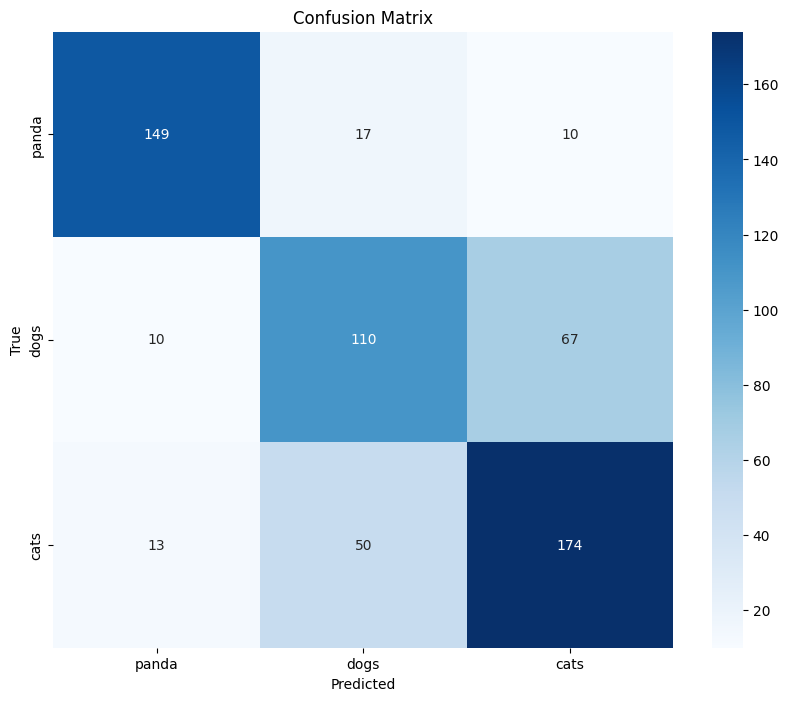

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       176
           1       0.62      0.59      0.60       187
           2       0.69      0.73      0.71       237

    accuracy                           0.72       600
   macro avg       0.73      0.72      0.72       600
weighted avg       0.72      0.72      0.72       600



In [25]:
# Example of testing the model with the best model
final_model = DeeperCNN(num_classes=3)  # Initialize the final model
model_path = 'DeeperCNN+new.pth'  # Path to the best model
final_model.load_state_dict(torch.load(model_path))  # Load the weights of the best model
criterion = nn.CrossEntropyLoss()  # Define the loss function

# Test the model
test_model(final_model, test_loader_new_augmentations, criterion)